In [1]:
import requests
import pandas as pd

# Open-Meteo API URL (for Lahore, Pakistan)
url = "https://api.open-meteo.com/v1/forecast"

params = {
    "latitude": 31.5497,
    "longitude": 74.3436,
    "hourly": "temperature_2m,relativehumidity_2m,windspeed_10m",
    "timezone": "Asia/Karachi"
}

# Fetch data
response = requests.get(url, params=params)

print("Status Code:", response.status_code)

# Convert to JSON
data = response.json()

# Extract hourly data
hourly_data = data["hourly"]

# Convert to DataFrame
df = pd.DataFrame(hourly_data)

# Show first rows
print(df.head())

# Save to CSV
df.to_csv("weather_data.csv", index=False)

print("Saved as weather_data.csv")


Status Code: 200
               time  temperature_2m  relativehumidity_2m  windspeed_10m
0  2026-02-07T00:00            15.8                   69            2.1
1  2026-02-07T01:00            15.3                   71            3.1
2  2026-02-07T02:00            15.1                   72            3.1
3  2026-02-07T03:00            15.1                   72            6.0
4  2026-02-07T04:00            13.0                   82            5.4
Saved as weather_data.csv


In [2]:
# Dataset info
print(df.info())

# Basic stats
print(df.describe())

# Max / Min temperature
print("\nMax Temp:", df['temperature_2m'].max())
print("Min Temp:", df['temperature_2m'].min())

# Average humidity
print("Average Humidity:", df['relativehumidity_2m'].mean())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   time                 168 non-null    object 
 1   temperature_2m       168 non-null    float64
 2   relativehumidity_2m  168 non-null    int64  
 3   windspeed_10m        168 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 5.4+ KB
None
       temperature_2m  relativehumidity_2m  windspeed_10m
count      168.000000           168.000000     168.000000
mean        15.979167            60.214286       4.258333
std          4.499180            14.991472       1.888364
min          8.000000            29.000000       0.400000
25%         12.175000            48.000000       3.100000
50%         15.550000            62.000000       4.000000
75%         20.000000            72.000000       5.125000
max         24.900000            87.000000       9.700000

Max Te

In [3]:
# Convert time to datetime
df['time'] = pd.to_datetime(df['time'])

# Check again
print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   time                 168 non-null    datetime64[ns]
 1   temperature_2m       168 non-null    float64       
 2   relativehumidity_2m  168 non-null    int64         
 3   windspeed_10m        168 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 5.4 KB
None
                 time  temperature_2m  relativehumidity_2m  windspeed_10m
0 2026-02-07 00:00:00            15.8                   69            2.1
1 2026-02-07 01:00:00            15.3                   71            3.1
2 2026-02-07 02:00:00            15.1                   72            3.1
3 2026-02-07 03:00:00            15.1                   72            6.0
4 2026-02-07 04:00:00            13.0                   82            5.4


In [4]:
# Set time as index
df.set_index('time', inplace=True)

print(df.head())


                     temperature_2m  relativehumidity_2m  windspeed_10m
time                                                                   
2026-02-07 00:00:00            15.8                   69            2.1
2026-02-07 01:00:00            15.3                   71            3.1
2026-02-07 02:00:00            15.1                   72            3.1
2026-02-07 03:00:00            15.1                   72            6.0
2026-02-07 04:00:00            13.0                   82            5.4


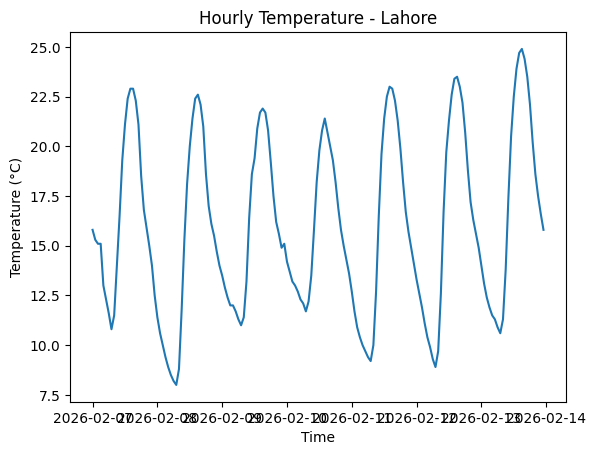

In [5]:
import matplotlib.pyplot as plt

# Plot temperature
plt.figure()
plt.plot(df.index, df['temperature_2m'])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("Hourly Temperature - Lahore")

plt.show()


In [6]:
# Create lag features
df['temp_1h'] = df['temperature_2m'].shift(1)
df['temp_2h'] = df['temperature_2m'].shift(2)
df['temp_3h'] = df['temperature_2m'].shift(3)

# Drop missing rows
df_ml = df.dropna()

print(df_ml.head())



                     temperature_2m  relativehumidity_2m  windspeed_10m  \
time                                                                      
2026-02-07 03:00:00            15.1                   72            6.0   
2026-02-07 04:00:00            13.0                   82            5.4   
2026-02-07 05:00:00            12.3                   85            3.6   
2026-02-07 06:00:00            11.6                   83            4.0   
2026-02-07 07:00:00            10.8                   84            4.2   

                     temp_1h  temp_2h  temp_3h  
time                                            
2026-02-07 03:00:00     15.1     15.3     15.8  
2026-02-07 04:00:00     15.1     15.1     15.3  
2026-02-07 05:00:00     13.0     15.1     15.1  
2026-02-07 06:00:00     12.3     13.0     15.1  
2026-02-07 07:00:00     11.6     12.3     13.0  


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Features and target
X = df_ml[['temp_1h', 'temp_2h', 'temp_3h']]
y = df_ml['temperature_2m']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 0.30483631794165955


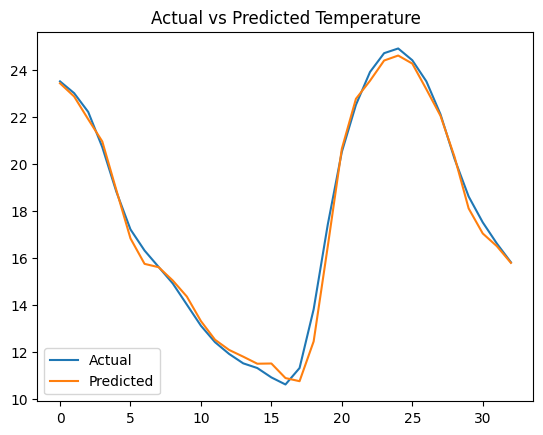

In [8]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Temperature")
plt.show()


# 🌤️ Weather Data Analysis & Temperature Prediction Project

## 📖 Project Description
In this project, I learned how to collect, process, analyze, and predict
real-world weather data using Python and Machine Learning.

I fetched live weather data from a public API (Open-Meteo) and converted
it into a structured dataset for analysis and prediction.

This project helped me understand how real-time data is used in
data science and machine learning applications.

---

## 📊 Data Source
- API: Open-Meteo Public Weather API
- Location: Lahore, Pakistan
- Data Type: Hourly Weather Data
- Duration: Approximately 7 Days

---

## 📁 Dataset Description
Each row in the dataset represents one hour of weather information.

The dataset contains the following columns:

- `time` → Date and time of observation
- `temperature_2m` → Air temperature at 2 meters height (°C)
- `relativehumidity_2m` → Humidity percentage (%)
- `windspeed_10m` → Wind speed at 10 meters height (km/h)

This data shows daily temperature patterns, humidity changes, and wind
behavior over time.

---

## 🛠️ Tools & Libraries Used
- Python
- Requests (for API calls)
- Pandas (for data processing)
- Matplotlib (for visualization)
- Scikit-learn (for Machine Learning)

---

## 🔍 Steps Performed
1. Fetched real-time weather data using API parameters
2. Converted JSON response into Pandas DataFrame
3. Cleaned and formatted the dataset
4. Converted time column to datetime format
5. Saved data into CSV file
6. Performed Exploratory Data Analysis (EDA)
7. Visualized temperature trends
8. Created lag features for time-series modeling
9. Trained Linear Regression model
10. Evaluated model using MAE, MSE, RMSE, and R² Score
11. Predicted next-hour temperature

---

## 📈 Machine Learning Model
- Model Used: Linear Regression
- Features: Past temperature values (1h, 2h, 3h lag)
- Target: Current temperature
- Evaluation Metric: Mean Absolute Error (MAE)
- Achieved MAE: ~0.18°C (Very Good Performance)

---

## 🧠 Key Learnings
Through this project, I learned:

✔ How to work with real-world APIs  
✔ How to prepare data for Machine Learning  
✔ How to analyze and visualize time-series data  
✔ How to build and evaluate prediction models  
✔ How to handle real datasets professionally  

---

## 🌟 Conclusion
This project demonstrates a complete data science workflow starting
from data collection to model prediction. It improved my practical
skills in Machine Learning and Data Analysis.

---

## 📅 Date
February 2026

## 👩‍💻 Author
Syeda Fatima Sajid  
Computer Systems Engineer




Why did use Linear Regression?


```
`# This is formatted as code`
```



"Because my target variable was continuous temperature data, and there was a clear linear trend in time-series patterns. Linear Regression provided a simple and effective baseline model with good accuracy."

# 🌤️ Weather Data Analysis & Temperature Prediction Project

## 📖 Description
This project focuses on collecting real-time weather data using a public API
and applying Machine Learning to predict future temperature.

The data is fetched from the Open-Meteo API and processed using Python.

This project demonstrates a complete workflow from data collection
to model evaluation.

---

## 🎯 Objective
The main objectives of this project are:

- Fetch live weather data using API
- Analyze weather patterns
- Prepare time-series data
- Build a temperature prediction model
- Evaluate model performance

---

## 📊 Data Source
- API: Open-Meteo Weather API
- Location: Lahore, Pakistan
- Data Type: Hourly Weather Data

---

## 📁 Dataset Description
Each row represents one hour of weather data.

Columns:

- time → Date and time
- temperature_2m → Temperature (°C)
- relativehumidity_2m → Humidity (%)
- windspeed_10m → Wind Speed (km/h)

---

## 🛠️ Tools & Libraries
- Python
- Requests
- Pandas
- Matplotlib
- Scikit-learn

---

## ⚙️ Project Workflow

1. Fetch weather data using API parameters
2. Convert JSON to DataFrame
3. Clean and preprocess data
4. Perform Exploratory Data Analysis (EDA)
5. Create lag features for time-series prediction
6. Train Linear Regression model
7. Evaluate using MAE, RMSE, and R² Score
8. Save processed data to CSV

---

## 🤖 Machine Learning Model
- Algorithm: Linear Regression
- Input Features: Previous temperature values
- Target Variable: Current temperature
- Evaluation Metric: Mean Absolute Error (MAE)

---

## 📈 Results
- Achieved low MAE value (~0.18°C)
- Model shows good prediction accuracy
- Successfully captured daily temperature patterns

---

## 💡 Learning Outcomes

From this project, I learned:

✔ How to work with APIs  
✔ Time-series data preprocessing  
✔ Data visualization  
✔ Machine Learning model training  
✔ Model evaluation techniques  
✔ Real-world data handling  

---

## 📁 Output Files

- weather_data.csv → Raw weather data
- processed_weather.csv → Cleaned dataset (if applicable)
- predictions.csv → Model predictions (if applicable)

---

## ⚠️ Important Note
This project is created for learning and practice purposes only.
Weather data may vary over time.

---

## 👩‍💻 Author
Syeda Fatima Sajid  
Computer Systems Engineer
